# DATA 606 - Winter 2026 - Assignment 3

Official due date: Thursday, February 12

**Extended due date: Tuesday, February 17**

In [2]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

# Model selection & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Pipelines & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

# Linear models
from sklearn.linear_model import LogisticRegression, SGDClassifier

# SVM models
from sklearn.svm import SVC, LinearSVC

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Text feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## 1. Fashion MNIST

This problem concerns the [Fashion MNIST classification dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist) from Kaggle.

Load the 60,000 training examples and split it into equal size ***training*** and ***validation*** subsets. (Below, I include code to load the training and testing sets from my GitHub site.)

Your goal is to fit the best model you can to the training set.

Your models should be pipelines consisting of a `sklearn.preprocessing.Normalizer` and one of the following models:

- `sklearn.linear_model.SGDClassifier`
- `sklearn.linear_model.LogisticRegression`
- `sklearn.svm.SVC`
- `sklearn.svm.LinearSVC`

Tune the regularization parameter `alpha` of `SGDClassifier` and the parameter `C` of `LogisticRegression`, `SVC`, and `LinearSVC` using `GridSearchCV` with $2$-fold cross validation. (If you use the default $5$-fold cross-validation, your search will take too long.) Produce cross-validated error plots indicating the optimal values of `C` for the various model types. Optionally, you can also tune the `kernel` parameter of `SVC`.

I suggest starting your analysis with a small subset of the training data, growing it as you identify good ranges of parameters.

Once you have settled on an optimal model, evaluate it on the test set and report the corresponding accuracy.

In [3]:
df_train = pd.read_parquet("https://github.com/mgreenbe/DATA607S2025/raw/refs/heads/main/data/fashion-mnist_train.parquet")
df_test = pd.read_parquet("https://github.com/mgreenbe/DATA607S2025/raw/refs/heads/main/data/fashion-mnist_test.parquet")

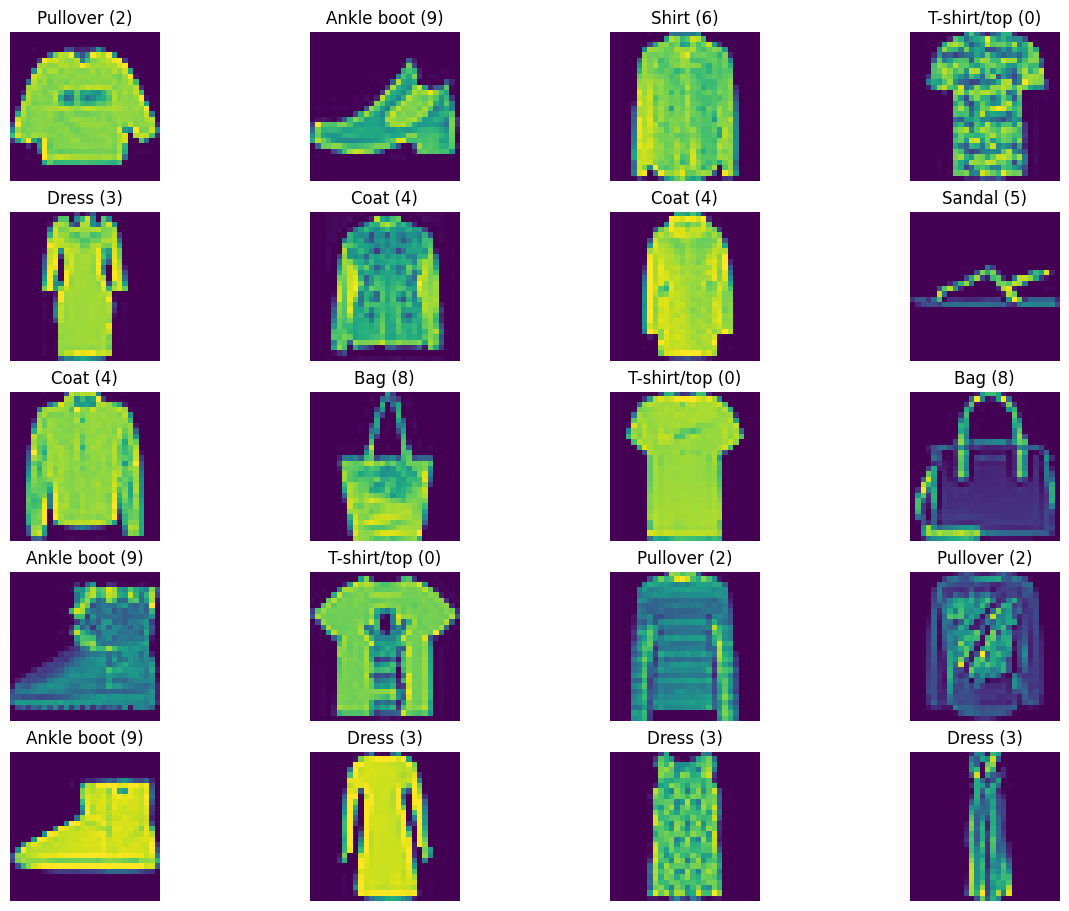

In [4]:
CLASSES = "T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot".split(",");

X = df_train.copy()
y = X.pop("label")

fig, axes = plt.subplots(5, 4, figsize=(12, 9), layout="constrained")
axes = axes.ravel()

for i, ax in enumerate(axes):
  x = X.iloc[i].values.reshape(28, 28)
  ax.set_axis_off()
  ax.imshow(x)
  ax.set_title(f"{CLASSES[y[i]]} ({y[i]})")

In [5]:
df_train.shape

(60000, 785)

In [6]:
df_train.sample(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
7745,3,0,0,0,0,0,0,1,2,2,...,51,0,0,0,0,0,0,0,0,0
32928,1,0,0,0,0,0,0,0,0,0,...,85,0,0,0,0,0,0,0,0,0
49624,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
51336,2,0,0,0,0,0,0,0,0,7,...,0,0,0,0,69,66,32,21,0,0
58273,3,0,0,0,0,0,0,1,0,0,...,179,186,75,0,0,0,0,0,0,0
14503,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40948,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59115,9,0,0,0,0,0,0,0,0,0,...,0,1,0,0,78,135,109,154,63,0
27914,2,0,0,0,0,0,0,0,0,0,...,0,2,0,66,110,97,0,0,0,0
42985,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(30000, 784) (30000, 784) (30000,) (30000,)


In [8]:
# Training subset
X_6k, _, y_6k, _ = train_test_split(
    X_train, y_train,
    train_size=6000,
    random_state=42,
    stratify=y_train
)

**SGD Classifier**

In [41]:
# SGD Classifier on 6k subsample

pipe_sgd = Pipeline([
    ("norm", Normalizer()),
    ("sgd", SGDClassifier(loss='log_loss', random_state=42))
])

gs = GridSearchCV(
    pipe_sgd,
    {"sgd__alpha": np.logspace(-7, -2, 9)},
    cv=2,
    scoring='accuracy',
    n_jobs=-1
)

gs.fit(X_6k, y_6k)

print(gs.best_params_)
print(gs.best_score_)

{'sgd__alpha': np.float64(3.1622776601683795e-05)}
0.8171666666666666


In [43]:
# SGD on 30k training set

alpha_grid = np.logspace(-6, -4, 5)

gs_30k = GridSearchCV(
    pipe_sgd,
    {"sgd__alpha": alpha_grid},
    cv=2,
    scoring="accuracy",
    n_jobs=-1
)

gs_30k.fit(X_train, y_train)

print("Best alpha:", gs_30k.best_params_)
print("Best CV accuracy:", gs_30k.best_score_)

Best alpha: {'sgd__alpha': np.float64(1e-05)}
Best CV accuracy: 0.8391333333333333


In [11]:
# SGD on 30k validation set

best_sgd = gs_30k.best_estimator_
val_acc = best_sgd.score(X_val, y_val)
print("Validation accuracy:", val_acc)

Validation accuracy: 0.8464666666666667


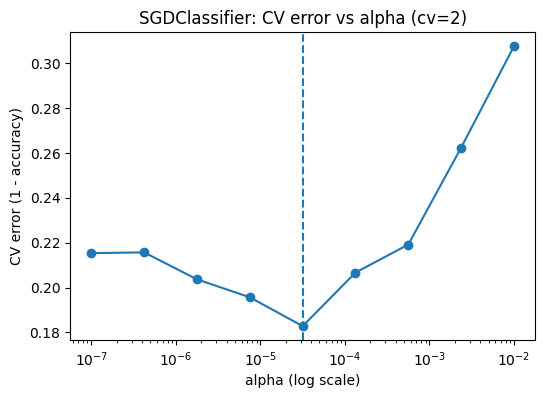

In [45]:
results = gs.cv_results_
alphas = results["param_sgd__alpha"].data.astype(float)
mean_acc = results["mean_test_score"]
mean_err = 1 - mean_acc

best_alpha = float(gs.best_params_["sgd__alpha"])

plt.figure(figsize=(6,4))
plt.semilogx(alphas, mean_err, marker="o")
plt.axvline(best_alpha, linestyle="--")
plt.xlabel("alpha (log scale)")
plt.ylabel("CV error (1 - accuracy)")
plt.title("SGDClassifier: CV error vs alpha (cv=2)")
plt.show()

**Logistic Regression**

In [12]:
# 1) LR pipeline
pipe_lr = Pipeline([
    ("norm", Normalizer()),
    ("lr", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
    ))
])

In [13]:
# 2) Start with 6k subset
C_grid_wide = np.logspace(-3, 2, 9)

gs_lr_6k = GridSearchCV(
    pipe_lr,
    {"lr__C": C_grid_wide},
    cv=2,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr_6k.fit(X_6k, y_6k)

print("LR (6k) best C:", gs_lr_6k.best_params_)
print("LR (6k) best CV accuracy:", gs_lr_6k.best_score_)

LR (6k) best C: {'lr__C': np.float64(5.623413251903491)}
LR (6k) best CV accuracy: 0.8226666666666667


In [63]:
C_grid_6k_b = [1, 3, 5, 10, 15, 20, 25, 30, 35]

gs_lr_6k_b = GridSearchCV(
    pipe_lr,
    {"lr__C": C_grid_6k_b},
    cv=2,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr_6k_b.fit(X_6k, y_6k)

print("LR (6k) B best C:", gs_lr_6k_b.best_params_)
print("LR (6k) B best CV accuracy:", gs_lr_6k_b.best_score_)


LR (6k) B best C: {'lr__C': 15}
LR (6k) B best CV accuracy: 0.8260000000000001


In [66]:
best_lr_6k_b = gs_lr_6k_b.best_estimator_
val_acc = best_lr_6k_b.score(X_val, y_val)

print("LR (6k B) validation accuracy:", val_acc)

LR (6k B) validation accuracy: 0.8411666666666666


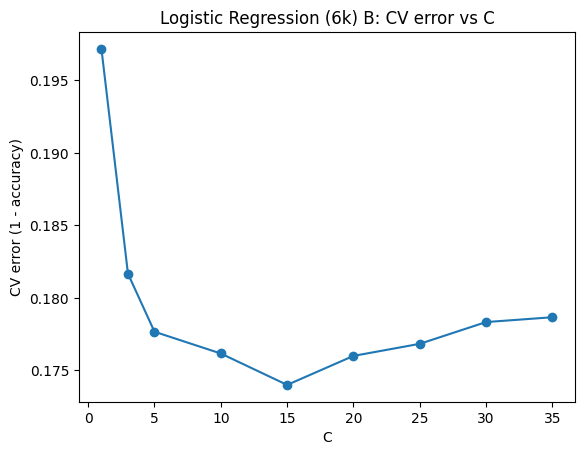

In [67]:

res_b = pd.DataFrame(gs_lr_6k_b.cv_results_)
res_b["C"] = res_b["param_lr__C"].astype(float)

# CV error = 1 - accuracy
res_b["cv_error"] = 1 - res_b["mean_test_score"]
res_b = res_b.sort_values("C")

plt.figure()
plt.plot(res_b["C"], res_b["cv_error"], marker="o")
plt.xlabel("C")
plt.ylabel("CV error (1 - accuracy)")
plt.title("Logistic Regression (6k) B: CV error vs C")
plt.show()

**Support Vector Machine**

In [16]:
pipe_svc = Pipeline([
    ("norm", Normalizer()),
    ("svc", SVC())
])

In [17]:
gs_svc_6k = GridSearchCV(
    pipe_svc,
    {"svc__C": np.logspace(-2, 1, 7)},
    scoring="accuracy",
    cv=2,
    n_jobs=-1
)

gs_svc_6k.fit(X_6k, y_6k)

print("SVC (6k) best C:", gs_svc_6k.best_params_)
print("SVC (6k) best CV accuracy:", gs_svc_6k.best_score_)

SVC (6k) best C: {'svc__C': np.float64(10.0)}
SVC (6k) best CV accuracy: 0.8456666666666667


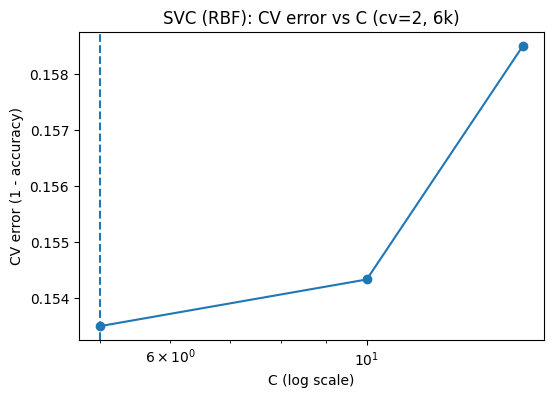

In [68]:
results = gs_svc_6k.cv_results_
Cs = results["param_svc__C"].data.astype(float)
mean_acc = results["mean_test_score"]
mean_err = 1 - mean_acc

best_C = float(gs_svc_6k.best_params_["svc__C"])

plt.figure(figsize=(6,4))
plt.semilogx(Cs, mean_err, marker="o")
plt.axvline(best_C, linestyle="--")
plt.xlabel("C (log scale)")
plt.ylabel("CV error (1 - accuracy)")
plt.title("SVC (RBF): CV error vs C (cv=2, 6k)")
plt.show()

**Linear Support Vector Machine**

In [19]:
pipe_lsvc = Pipeline([
    ("norm", Normalizer()),
    ("lsvc", LinearSVC())
])

In [20]:
gs_lsvc_6k = GridSearchCV(
    pipe_lsvc,
    {"lsvc__C": np.logspace(-2, 1, 7)},
    cv=2,
    scoring="accuracy",
    n_jobs=-1
)

gs_lsvc_6k.fit(X_6k, y_6k)

print("LinearSVC (6k) best C:", gs_lsvc_6k.best_params_)
print("LinearSVC (6k) best CV accuracy:", gs_lsvc_6k.best_score_)


LinearSVC (6k) best C: {'lsvc__C': np.float64(3.1622776601683795)}
LinearSVC (6k) best CV accuracy: 0.8215


In [22]:
gs_lsvc_30k = GridSearchCV(
    pipe_lsvc,
    {"lsvc__C": [1, 2, 3, 4, 5]},
    cv=2,
    scoring="accuracy",
    n_jobs=-1
)

gs_lsvc_30k.fit(X_train, y_train)

print("LinearSVC (30k) best C:", gs_lsvc_30k.best_params_)
print("LinearSVC (30k) best CV accuracy:", gs_lsvc_30k.best_score_)

LinearSVC (30k) best C: {'lsvc__C': 3}
LinearSVC (30k) best CV accuracy: 0.8449


In [23]:
best_lsvc = gs_lsvc_30k.best_estimator_
print("LinearSVC validation accuracy:", best_lsvc.score(X_val, y_val))

LinearSVC validation accuracy: 0.8506666666666667


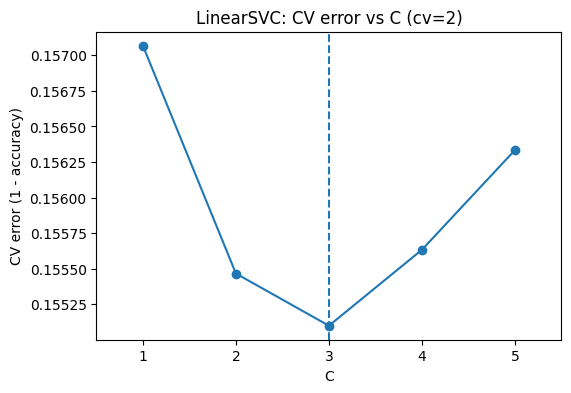

In [39]:
results = gs_lsvc_30k.cv_results_

Cs = results["param_lsvc__C"].data.astype(float)
mean_acc = results["mean_test_score"]
mean_err = 1 - mean_acc

# Sort by C for a clean line
order = np.argsort(Cs)
Cs = Cs[order]
mean_err = mean_err[order]

best_C = float(gs_lsvc_30k.best_params_["lsvc__C"])

# Tight x-limits (small padding)
pad = 0.5
xmin = max(0, Cs.min() - pad)
xmax = Cs.max() + pad

plt.figure(figsize=(6,4))
plt.plot(Cs, mean_err, marker="o")
plt.axvline(best_C, linestyle="--")
plt.xlim(xmin, xmax)
plt.xlabel("C")
plt.ylabel("CV error (1 - accuracy)")
plt.title("LinearSVC: CV error vs C (cv=2)")
plt.show()

## 2. SMS spam filtering

In this activity, we'll try to flag spam SMS messages based on the text of the message.

The dataset comes from the UCI Machine Learning Repository ([link](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)).

I preprocessed it a bit and included code to load the dataset below. Below, I include code to load the dataset from my GitHub site.

### Manual feature extraction

If you examine some of the messages in the dataset, you'll notice some patterns that you might exploit for classifying spam messages.

Add the following features to the dataframe:

- `length`, the length of a message, in characters,

- `num_caps`, the number of capital letters in a message,

- `proportion_caps` the proportion of capital letters in a message,

- `num_digits`, the number of digits in a message,

- `proportion_digits` the proportion of digits in a message,

- binary features `contains_<char>` indicating whether each of the following characters occurs in a message:
`@`, `#`, `$`, `*`, `/`, `:`, `-`, `+`, `£`, `(`, `)`, `[`, `]`, `;`, `<`, `>`, `?`

Compute cross-validated accuracy, $F_1$, precision, and recall metrics for `LogisticRegression`, `SGDClassifier`, and `LinearSVC` models fit to the the data using these features that you extracted.
If you do this using `cross_val_score`, you'll need to loop over the metrics yourself. If you use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead (try it!) you can pass in a list of metrics.

How do the models compare across the various metrics?

### Feature extraction with `CountVectorizer`

Compute cross-validated accuracy, $F_1$, precision, and recall metrics for `LogisticRegression`, `SGDClassifier`, `LinearSVC`, and `MultinomialNB` models fit to the data, extracting features using `CountVectorizer`.
How do the models compare across the various metrics?

Can you improve performance by tuning parameters of the vectorizer or the classifier? Does swapping out `CountVectorizer` with `TfidfVectorizer` improve any metrics?


In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/mgreenbe/DATA607S2025/refs/heads/main/data/sms_spam.csv", dtype={"is_spam": bool})
df.tail()

,is_spam,message
5569,True,This is the 2nd time we have tried 2 contact u...
5570,False,Will ü b going to esplanade fr home?
5571,False,"Pity, * was in mood for that. So...any other s..."
5572,False,The guy did some bitching but I acted like i'd...
5573,False,Rofl. Its true to its name


In [25]:
df_manual = df.copy()

# Length
df_manual["length"] = df_manual["message"].str.len()

# Capitals
df_manual["num_caps"] = df_manual["message"].apply(
    lambda x: sum(1 for c in x if c.isupper())
)
df_manual["proportion_caps"] = df_manual["num_caps"] / df_manual["length"]

# Digits
df_manual["num_digits"] = df_manual["message"].apply(
    lambda x: sum(1 for c in x if c.isdigit())
)
df_manual["proportion_digits"] = df_manual["num_digits"] / df_manual["length"]

# Special characters
special_chars = ["@", "#", "$", "*", "/", ":", "-", "+", "£", "(", ")", "[", "]", ";", "<", ">", "?"]

for ch in special_chars:
    df_manual[f"contains_{ch}"] = df_manual["message"].str.contains(ch, regex=False).astype(int)

df_manual.head()


,is_spam,message,length,num_caps,proportion_caps,num_digits,proportion_digits,contains_@,contains_#,contains_$,...,contains_+,contains_£,contains_(,contains_),contains_[,contains_],contains_;,contains_<,contains_>,contains_?
0,False,"Go until jurong point, crazy.. Available only ...",111,3,0.027027,0,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,Ok lar... Joking wif u oni...,29,2,0.068966,0,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,0.064516,25,0.16129,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,False,U dun say so early hor... U c already then say...,49,2,0.040816,0,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,"Nah I don't think he goes to usf, he lives aro...",61,2,0.032787,0,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X_manual = df_manual.drop(columns=["message", "is_spam"])
y = df_manual["is_spam"]


In [27]:
scoring = ["accuracy", "precision", "recall", "f1"]

models_manual = {
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "SGDClassifier": SGDClassifier(loss="log_loss"),
    "LinearSVC": LinearSVC()
}

results_manual = {}

for name, model in models_manual.items():
    scores = cross_validate(model, X_manual, y, cv=5, scoring=scoring)
    results_manual[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }

pd.DataFrame(results_manual).T


,accuracy,precision,recall,f1
LogisticRegression,0.974165,0.945546,0.856796,0.898831
SGDClassifier,0.970039,0.940885,0.828644,0.881032
LinearSVC,0.976318,0.955752,0.863472,0.907115


In [28]:
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df["message"])


In [29]:
models_vector = {
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "SGDClassifier": SGDClassifier(loss="log_loss"),
    "LinearSVC": LinearSVC(),
    "MultinomialNB": MultinomialNB()
}

results_counts = {}

for name, model in models_vector.items():
    scores = cross_validate(model, X_counts, y, cv=5, scoring=scoring)
    results_counts[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }

pd.DataFrame(results_counts).T


,accuracy,precision,recall,f1
LogisticRegression,0.981701,0.983622,0.878219,0.927842
SGDClassifier,0.983136,0.985422,0.887588,0.933785
LinearSVC,0.984213,0.992590,0.888922,0.937821
MultinomialNB,0.979727,0.911151,0.941145,0.925606


In [31]:
vectorizer = CountVectorizer(
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
)

X_counts = vectorizer.fit_transform(df["message"])

results_counts_improved = {}

for name, model in models_vector.items():
    scores = cross_validate(model, X_counts, y, cv=5, scoring=scoring)
    results_counts_improved[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }

pd.DataFrame(results_counts_improved).T


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,accuracy,precision,recall,f1
LogisticRegression,0.979549,0.996922,0.850139,0.917492
SGDClassifier,0.981701,0.995382,0.867526,0.926933
LinearSVC,0.983496,0.995498,0.880895,0.934586
MultinomialNB,0.986186,0.968616,0.927785,0.947263


In [32]:
vectorizer_tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
)

X_tfidf = vectorizer_tfidf.fit_transform(df["message"])


In [33]:
results_tfidf = {}

for name, model in models_vector.items():
    scores = cross_validate(model, X_tfidf, y, cv=5, scoring=scoring)
    results_tfidf[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }

pd.DataFrame(results_tfidf).T


,accuracy,precision,recall,f1
LogisticRegression,0.949409,0.989239,0.629262,0.768449
SGDClassifier,0.971117,0.990203,0.792528,0.880073
LinearSVC,0.980086,0.986386,0.863526,0.920585
MultinomialNB,0.973986,1.000000,0.805906,0.892416
